# NFL Big Data - ETL & Model

## Overview
- Attempting to build a dataset with categorical inputs from plays and week1 datasets 
    - create game and play id variable
    - encoding different variables, setting play action/motion from event to variable
- Create 4 Event time snapshots for players on the field
    - Line set
    - Ball snap
    - Pass forward
    - Pass arrived
- Merge data
- Target classification variable
    - Pass Outcome
        - Incomplete
        - Complete
        - TD
        - INT

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns
import re
from datetime import date, datetime
import glob
import plotly.figure_factory as ff
from scipy.spatial import distance
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.animation import FuncAnimation

In [2]:
pwd

'/home/tguardi/Projects/NFL_Big_Data'

In [3]:
path = "/home/tguardi/Projects/NFL_Big_Data"

# Load Data

In [4]:
week1 = pd.read_csv(path + "/week1.csv")
plays = pd.read_csv(path + '/plays.csv')

#### Create game/play id variable

In [5]:
#Create additional column on week1 for a unique identifier of gameId and playId
week1['gp'] = week1['gameId'].astype(str)+ '_' + week1['playId'].astype(str)
plays['gp'] = plays['gameId'].astype(str)+ '_' + plays['playId'].astype(str)

# Pipeline

#### Who's on offense and who's on defense?

In [6]:
#Create temp df for only QBs. We know QBs are always attacking so we will knnow what game/play/team combination
#corresponds to players that are attacking
qbs = week1[(week1['event'] == 'pass_forward')&(week1['position'] == 'QB')]

In [7]:
#We drop all columns except team, gp, our QB's x and y coordinates which are the ones were interested in
qbs.drop(qbs.columns.difference(['team','gp', 'x', 'y']), 1, inplace=True)

In [8]:
#We drop duplicates, as we don't really need the same information for each frame
qbs.drop_duplicates(subset=['gp'], inplace = True)

In [9]:
#We merge our qbs data frame with our week1 dataframe based on game/play id
week1 = week1.merge(qbs, on ="gp", suffixes=('', '_qb_pass_forward'))

#### Encode column 
- might be unneccesarry at this point. 

In [10]:
#We create a new column called "offense" if our row's 'team' agrees with that of the appended qbs
#If it does, that means the player is on the same team as the QB and is attacking. In this case, we set our 
#value to True. If it does not, it means the player is defending, and we set our value to False
week1['offense'] = np.where(week1['team'] == week1['team_qb_pass_forward'], 1, 0)

In [11]:
#We drop our second teams column
week1.drop('team_qb_pass_forward', axis = 1, inplace = True)

#### Tie Play action and Man in Motion to 'gp'

- Need to link gp to play action

#### Something off about these results

In [12]:
week1_playaction = set(week1['gp'].loc[week1['event'] == 'play_action'])
len(week1_playaction)

170

In [13]:
week1_motion = set(week1['gp'].loc[week1['event'] == 'man_in_motion'])
len(week1_motion)

35

In [14]:
df = week1.loc[np.where(week1['event'] == 'play_action', 1, 0)]
df['gp']

0    2018090600_75
0    2018090600_75
0    2018090600_75
0    2018090600_75
0    2018090600_75
         ...      
0    2018090600_75
0    2018090600_75
0    2018090600_75
0    2018090600_75
0    2018090600_75
Name: gp, Length: 918456, dtype: object

In [15]:
#### np.where(week1['event'] == 'man_in_motion', 1, 0)

## DF with only ball_snap and pass_outcome rows

In [16]:
passing_df = week1[week1['event'].isin(['pass_outcome_touchdown', 
                                        'pass_outcome_caught',
                                        'pass_outcome_incomplete',
                                        'pass_outcome_interception'])]

In [17]:
passing_df = week1[week1['event'].isin(['ball_snap','line_set','pass_forward',
                                        'play_action','man_in_motion'])]

In [18]:
passing_df.shape

(32691, 23)

### Not sure this is worth doing right here. Need to refine ETL process. 

In [19]:
#### New Encoded Columns

# Create encoded Play Action column
passing_df['play_action'] = np.where(passing_df['event'] == 'play_action', 1, 0)
# Create encoded Man in Motion column
passing_df['motion'] = np.where(passing_df['event'] == 'man_in_motion', 1, 0)

# Fill 
passing_df['route'] = passing_df['route'].fillna('NONE')

passing_df.play_action.value_counts()

# passing_df.loc[passing_df['nflId'].isna()]

0    30223
1     2468
Name: play_action, dtype: int64

In [20]:
#Let's try just having the ball_snap positions AND appending the outcome to a new column

In [21]:
passing_df.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,gameId,playId,playDirection,route,gp,x_qb_pass_forward,y_qb_pass_forward,offense,play_action,motion
140,2018-09-07T01:07:15.599Z,91.74,26.67,0.00,0.00,0.01,277.41,235.01,ball_snap,310.0,...,2018090600,75,left,NONE,2018090600_75,96.43,26.78,1,0,0
141,2018-09-07T01:07:15.599Z,88.89,36.50,0.01,0.01,0.00,104.49,36.45,ball_snap,79848.0,...,2018090600,75,left,NONE,2018090600_75,96.43,26.78,0,0,0
142,2018-09-07T01:07:15.599Z,91.36,44.14,0.00,0.01,0.02,289.53,49.86,ball_snap,2495454.0,...,2018090600,75,left,HITCH,2018090600_75,96.43,26.78,1,0,0
143,2018-09-07T01:07:15.599Z,86.47,22.03,0.18,0.07,0.01,71.89,82.30,ball_snap,2495613.0,...,2018090600,75,left,NONE,2018090600_75,96.43,26.78,0,0,0
144,2018-09-07T01:07:15.599Z,90.78,36.16,0.00,0.00,0.00,259.19,294.93,ball_snap,2533040.0,...,2018090600,75,left,HITCH,2018090600_75,96.43,26.78,1,0,0


### Outcomes, Target Variable

In [22]:
outcomes = week1[['event','playId']][week1['event'].isin(['pass_outcome_touchdown',
                                                          'pass_outcome_caught',
                                                          'pass_outcome_incomplete',
                                                          'pass_outcome_interception'])].drop_duplicates()

In [23]:
outcomes.columns = ['outcome', 'playId']

In [24]:
outcomes.head()

,outcome,playId
714,pass_outcome_caught,75
1484,pass_outcome_incomplete,146
2156,pass_outcome_incomplete,168
3038,pass_outcome_caught,190
3746,pass_outcome_incomplete,256


In [25]:
# merge in the outcomes
passing_df = passing_df.merge(outcomes, on='playId')
passing_df.shape

(35369, 26)

In [26]:
passing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35369 entries, 0 to 35368
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35369 non-null  object 
 1   x                  35369 non-null  float64
 2   y                  35369 non-null  float64
 3   s                  35369 non-null  float64
 4   a                  35369 non-null  float64
 5   dis                35369 non-null  float64
 6   o                  32965 non-null  float64
 7   dir                32965 non-null  float64
 8   event              35369 non-null  object 
 9   nflId              32965 non-null  float64
 10  displayName        35369 non-null  object 
 11  jerseyNumber       32965 non-null  float64
 12  position           32965 non-null  object 
 13  frameId            35369 non-null  int64  
 14  team               35369 non-null  object 
 15  gameId             35369 non-null  int64  
 16  playId             353

## Plays Data
- Plays data has some interesting categorical features that will help us categorize different types of plays and should serve as good predictors for our classifier

- More work needed on bringing this in
    - Game clock quantifier - Do we toss?|
    - Absoluate yard line number = distance to goal

In [27]:
# plays = plays[['playDescription', 'quarter', 'down', 'yardsToGo',
#                'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
#                 'offenseFormation', 'personnelO', 'defendersInTheBox',
#                 'numberOfPassRushers', 'personnelD', 'typeDropback',
#                 'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
#                 'absoluteYardlineNumber','gp']]
plays = plays[['playDescription', 'quarter', 'down', 'yardsToGo',
               'possessionTeam', 'playType','offenseFormation', 'personnelO', 
               'defendersInTheBox','numberOfPassRushers', 'personnelD', 
               'typeDropback','preSnapVisitorScore', 'preSnapHomeScore',
                'absoluteYardlineNumber','gp']]


#### Absolute yardline number into distance to TD

In [70]:
#################

# YOUR CODE HERE #

#################

#### Game Clock - What to do with?
    - Is 2 minute drill encoding? 1 for yes, 0 for other

In [28]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   playDescription         19239 non-null  object 
 1   quarter                 19239 non-null  int64  
 2   down                    19239 non-null  int64  
 3   yardsToGo               19239 non-null  int64  
 4   possessionTeam          19239 non-null  object 
 5   playType                19239 non-null  object 
 6   offenseFormation        19098 non-null  object 
 7   personnelO              19210 non-null  object 
 8   defendersInTheBox       19177 non-null  float64
 9   numberOfPassRushers     18606 non-null  float64
 10  personnelD              19210 non-null  object 
 11  typeDropback            18600 non-null  object 
 12  preSnapVisitorScore     18600 non-null  float64
 13  preSnapHomeScore        18600 non-null  float64
 14  absoluteYardlineNumber  18600 non-null

## Join passing_df and plays

In [29]:
week1_plays = passing_df.set_index('gp').join(plays.set_index('gp'))

In [30]:
# check work
week1_plays

,time,x,y,s,a,dis,o,dir,event,nflId,...,playType,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber
gp,,,,,,,,,,,,,,,,,,,,,
2018090600_1037,2018-09-07T01:48:46.400Z,68.36,35.20,0.00,0.00,0.00,257.83,265.68,ball_snap,2507763.0,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,2018-09-07T01:48:46.400Z,72.08,23.78,0.00,0.00,0.00,265.74,275.50,ball_snap,2532842.0,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,2018-09-07T01:48:46.400Z,66.62,35.20,0.00,0.00,0.00,101.79,197.17,ball_snap,2539334.0,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,2018-09-07T01:48:46.400Z,65.59,15.30,0.00,0.00,0.01,73.64,308.71,ball_snap,2539653.0,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,2018-09-07T01:48:46.400Z,69.45,17.12,0.23,0.09,0.21,309.85,231.38,ball_snap,2540158.0,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018091001_980,2018-09-11T03:02:48.900Z,46.39,28.59,3.32,3.06,0.32,73.04,22.73,pass_forward,2556593.0,...,play_type_pass,I_FORM,"2 RB, 1 TE, 2 WR",8.0,5.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,7.0,7.0,48.0
2018091001_980,2018-09-11T03:02:48.900Z,49.03,20.24,3.23,2.75,0.31,168.80,192.67,pass_forward,2556885.0,...,play_type_pass,I_FORM,"2 RB, 1 TE, 2 WR",8.0,5.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,7.0,7.0,48.0
2018091001_980,2018-09-11T03:02:48.900Z,32.60,31.11,6.15,4.70,0.61,321.82,314.93,pass_forward,2558183.0,...,play_type_pass,I_FORM,"2 RB, 1 TE, 2 WR",8.0,5.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,7.0,7.0,48.0


## Final Model Prep
- Columns to drop
    - playDescription

In [31]:
# list of columns to drop
drop_list = ['time','nflId','displayName','jerseyNumber','position',
             'frameId','team','gameId','playId','playDescription']

In [32]:
# do the drops
week1_plays = week1_plays.drop(drop_list, axis = 1)

### Fill na's in the laziest way possible
- might not want to stick with this

In [34]:
week1_plays = week1_plays.interpolate()

In [35]:
week1_plays = week1_plays.fillna(method='ffill')

,x,y,s,a,dis,o,dir,event,playDirection,route,...,playType,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber
gp,,,,,,,,,,,,,,,,,,,,,
2018090600_1037,68.36,35.20,0.00,0.00,0.00,257.83,265.68,ball_snap,left,HITCH,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,72.08,23.78,0.00,0.00,0.00,265.74,275.50,ball_snap,left,NONE,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,66.62,35.20,0.00,0.00,0.00,101.79,197.17,ball_snap,left,NONE,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,65.59,15.30,0.00,0.00,0.01,73.64,308.71,ball_snap,left,NONE,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
2018090600_1037,69.45,17.12,0.23,0.09,0.21,309.85,231.38,ball_snap,left,OUT,...,play_type_pass,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,3.0,0.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018091001_980,46.39,28.59,3.32,3.06,0.32,73.04,22.73,pass_forward,left,NONE,...,play_type_pass,I_FORM,"2 RB, 1 TE, 2 WR",8.0,5.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,7.0,7.0,48.0
2018091001_980,49.03,20.24,3.23,2.75,0.31,168.80,192.67,pass_forward,left,NONE,...,play_type_pass,I_FORM,"2 RB, 1 TE, 2 WR",8.0,5.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,7.0,7.0,48.0
2018091001_980,32.60,31.11,6.15,4.70,0.61,321.82,314.93,pass_forward,left,NONE,...,play_type_pass,I_FORM,"2 RB, 1 TE, 2 WR",8.0,5.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,7.0,7.0,48.0


# Define X and y

### X_prep
- create X, check shape
- Get dummies on X (29 to 119 features)

In [36]:
# drop outcome to create X 
X = week1_plays.drop('outcome', axis = 1)
X.shape

(35369, 29)

In [49]:
# Create dummies for X 
X = pd.get_dummies(X)

In [68]:
# check shape
X.shape

(35369, 119)

### Y Prep

In [83]:
# Define y
y = week1_plays.outcome
y.value_counts()

pass_outcome_caught          20203
pass_outcome_incomplete      13339
pass_outcome_interception     1195
pass_outcome_touchdown         632
Name: outcome, dtype: int64

In [84]:
# Encode our outcome column
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

### Train Test Split

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Model

In [80]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

In [81]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
y_preds = rf.predict(X_test)

In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5949
           1       0.85      0.83      0.84      4106
           2       0.88      0.85      0.86       383
           3       0.67      0.71      0.69       173

    accuracy                           0.87     10611
   macro avg       0.82      0.82      0.82     10611
weighted avg       0.87      0.87      0.86     10611



In [64]:
rf_imp = pd.Series(rf.feature_importances_, index=X.columns)
rf_sorted = rf_imp.sort_values(ascending=False)

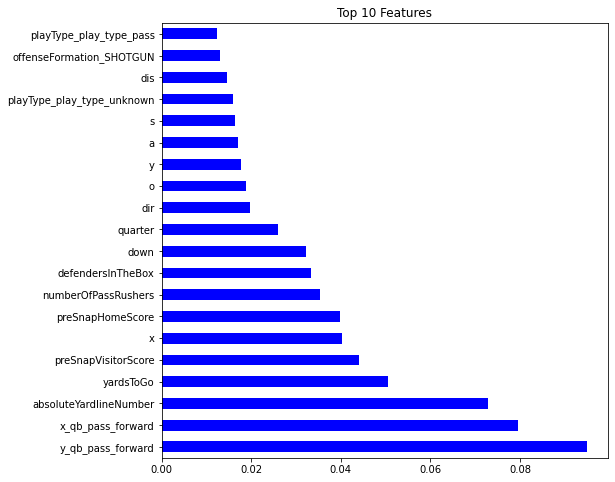

In [67]:
rf_sorted[:20].plot(kind='barh', color='blue',figsize=(8,8),title='Top 10 Features')
plt.show()

## Additional Questions/Items

In [ ]:
#Does player performance decrease as the season goes on?
#   How do you define defensive performance and its increase/decrease?

#What are coverage schemes (man, zone, etc) that the defense employs? What coverage options tend to be better performing?
#   Better performing = no completion, no gain. Fourth down incompletion. Interceptions.

#Which players are the best at closely tracking receivers as they try to get open?
#   Height, weight, age, schools, teams, proximity to offensive player. How do you define "open" in your program?

#Which players are the best at closing on receivers when the ball is in the air?
#   Height, weight, age, schools, teams, proximity to offensive player

#Which players are the best at defending pass plays when the ball arrives?
#   Height, weight, age, schools, teams

#Is there any way to use player tracking data to predict whether or not certain penalties – for example, defensive pass interference – will be called?
#   Movement, formation, adjustments, orientations, player IDs, home/away

#Who are the NFL’s best players against the pass?
#   Most interceptions, blocks?

#How does a defense react to certain types of offensive plays?
#   Movement, formation, adjustments

#Is there anything about a player – for example, their height, weight, experience, speed, or position – that can be used to predict their performance on defense?
#   How do you measure performance on defense?

#Are there favorable matchups to specific QBs/profiles of QBs/offensive lineups?
#   Physical features of all players in offensive lineup and defensive lineup, result of play